In [9]:
import numpy as np
import nolearn
import sklearn.linear_model as lm
import scipy.stats as sps
import math
import pandas as pd

from decimal import Decimal
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from lasagne import layers
from nolearn.lasagne import NeuralNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import custom_funcs as cf
cf.init_seaborn('white', 'notebook')
from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights

In [18]:
# Read in the protease inhibitor data
data, drug_cols, feat_cols = cf.read_data('hiv-protease-data.csv', n_data_cols=8)
print(len(data))
# Read in the consensus data
consensus_map = cf.read_consensus('hiv-protease-consensus.fasta')

# Clean the data
data = cf.clean_data(data, feat_cols, consensus_map)

# Identify feature columns
data = cf.drop_ambiguous_sequences(data, feat_cols)
data.dropna(inplace=True, subset=feat_cols)
data

1808


,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P1,P2,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
SeqID,,,,,,,,,,,,,,,,,,,,,
4432,1.5,NaN,1.0,NaN,2.2,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4664,3.1,NaN,8.7,NaN,32.0,16.9,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5221,NaN,NaN,0.8,0.8,1.2,0.7,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
5279,8.3,79.0,16.0,12.0,600.0,1000.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5444,2.7,21.0,24.0,6.1,42.0,132.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
5462,2.1,16.0,12.0,22.0,15.0,82.0,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
5464,2.1,NaN,22.2,7.8,24.7,104.8,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
5681,NaN,NaN,26.0,25.0,37.0,7.4,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
6024,NaN,NaN,8.3,3.0,22.0,3.4,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F


# Audience Choice

Which drug would you like to see? 

- FPV
- ATV
- IDV
- LPV
- NFV
- SQV
- TPV
- DRV

In [19]:
# Audience choice: Which drug would you like?
print(drug_cols)

DRUG = 'FPV'

Index(['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV'], dtype='object')


In [20]:
feat_cols

Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41',
       'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51',
       'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61',
       'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71',
       'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P81',
       'P82', 'P83', 'P84', 'P85', 'P86', 'P87', 'P88', 'P89', 'P90', 'P91',
       'P92', 'P93', 'P94', 'P95', 'P96', 'P97', 'P98', 'P99'],
      dtype='object')

In [26]:
# Split data into predictor variables and dependent variables.
# Predictors are the sequence features
# Dependent are the drug resistance values
def binarize_data(data, feat_cols, DRUG):
    data = resample(data)
    X, Y = cf.split_data_xy(data, feat_cols, DRUG)

    # Binarize the sequence features such that there are 99 x 20 columns in total.
    lb = LabelBinarizer()
    lb.fit(list('CHIMSVAGLPTRFYWDNEQK'))

    X_binarized = pd.DataFrame()

    for col in X.columns:
        binarized_cols = lb.transform(X[col])

        for i, c in enumerate(lb.classes_):
            X_binarized[col + '_' + c] = binarized_cols[:,i]
    return X_binarized, Y

X_binarized, Y = binarize_data(data, feat_cols, DRUG)

/home/ericmjl/hiv-resistance-prediction/custom_funcs.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  subset.dropna(inplace=True)


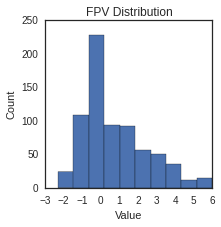

In [27]:
# View distribution of drug resistance values
import matplotlib.pyplot as plt
std = (3,3)
fig = cf.plot_Y_histogram(Y, DRUG, figsize=std)

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


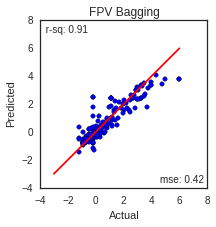

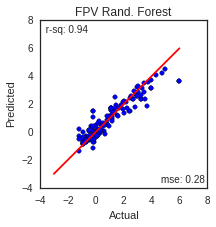

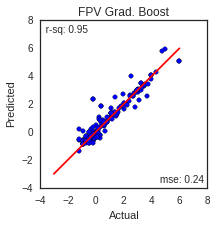

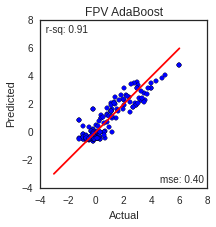

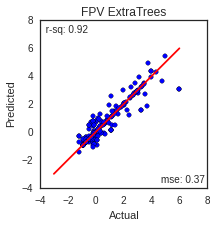

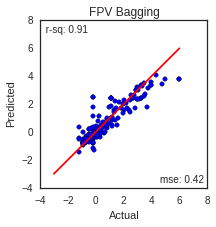

In [28]:
# Split data into training and testing set.
tts_data = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y)

# Train a bunch of ensemble regressors:
## Random Forest
kwargs = {'n_jobs':-1, 'n_estimators':1000}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_data, model=RandomForestRegressor, modelargs=kwargs)
## Gradient Boosting
kwargs = {'n_estimators':1000}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_data, model=GradientBoostingRegressor, modelargs=kwargs)
## AdaBoost
kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_data, model=AdaBoostRegressor, modelargs=kwargs)
## ExtraTrees
etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_data, model=ExtraTreesRegressor)
## Bagging
bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_data, model=BaggingRegressor)

# Plot the results of regression
rfr_fig = cf.scatterplot_results(rfr_preds, Y_test, rfr_mse, rfr_r2, DRUG, 'Rand. Forest', figsize=std)
# plt.savefig('figures/{0} Random Forest.pdf'.format(DRUG), bbox_inches='tight')
cf.scatterplot_results(gbr_preds, Y_test, gbr_mse, gbr_r2, DRUG, 'Grad. Boost', figsize=std)
cf.scatterplot_results(abr_preds, Y_test, abr_mse, abr_r2, DRUG, 'AdaBoost', figsize=std)
cf.scatterplot_results(etr_preds, Y_test, etr_mse, etr_r2, DRUG, 'ExtraTrees', figsize=std)
cf.scatterplot_results(bgr_preds, Y_test, bgr_mse, bgr_r2, DRUG, 'Bagging', figsize=std)

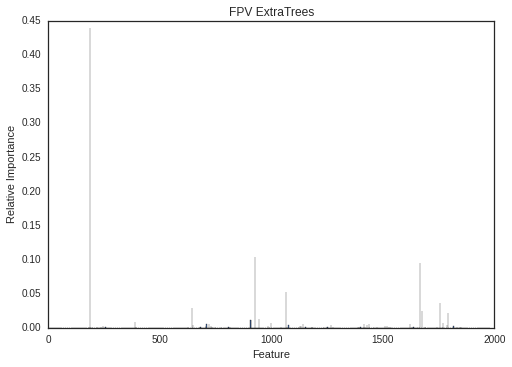

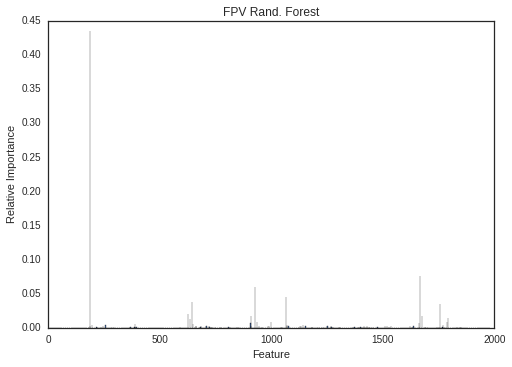

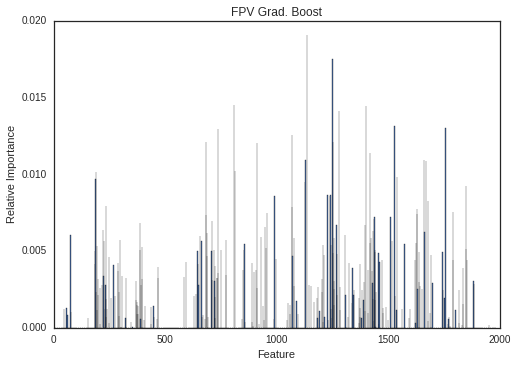

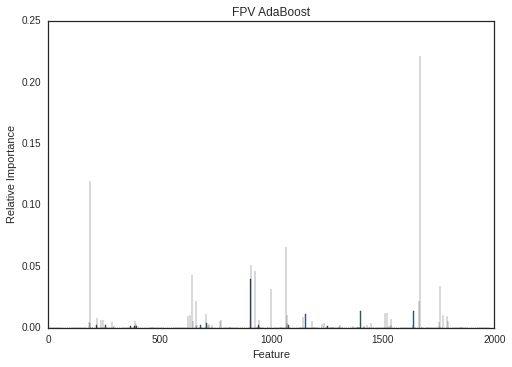

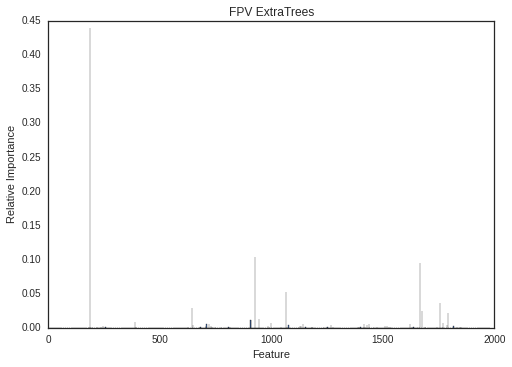

In [29]:
# Grab the feature importances - that is, how important a particular feature is for predicting drug resistance
cf.barplot_feature_importances(rfr, DRUG, 'Rand. Forest')
cf.barplot_feature_importances(gbr, DRUG, 'Grad. Boost')
cf.barplot_feature_importances(abr, DRUG, 'AdaBoost')
cf.barplot_feature_importances(etr, DRUG, 'ExtraTrees')
# cf.barplot_feature_importances(bgr, DRUG, 'Bagging') ## feature_importances_ do not exist for bagging

In [30]:
# Extract a table version of feature importance
rfr_fi = cf.extract_mutational_importance(rfr, X_test)
gbr_fi = cf.extract_mutational_importance(gbr, X_test)
abr_fi = cf.extract_mutational_importance(abr, X_test)

# Join data to compare random forest and gradient boosting.
# joined = rfr_fi.set_index(0).join(gbr_fi.set_index(0), lsuffix='r', rsuffix='g')
# sps.spearmanr(joined['1r'], joined['1g'])

rfr_fi

,0,1
0,P10_L,0.435105
1,P84_I,0.076132
2,P47_I,0.059716
3,P54_I,0.045847
4,P33_F,0.037099
5,P88_S,0.034475
6,P32_I,0.020380
7,P46_M,0.017613
8,P84_V,0.017395
9,P90_M,0.013866


/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


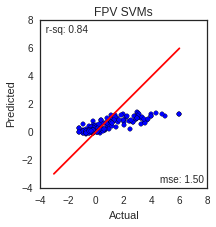

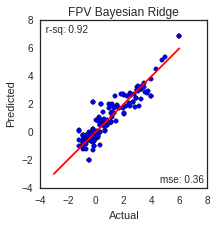

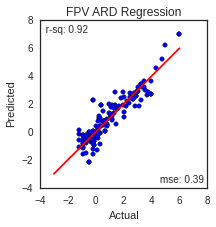

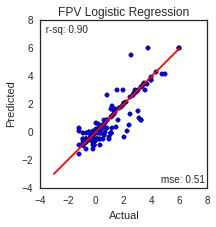

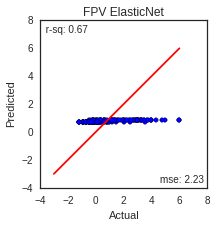

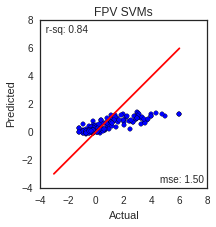

In [31]:
# Train a bunch of linear model learners for comparison.
brr, brr_preds, brr_mse, brr_r2 = cf.train_model(*tts_data, model=lm.BayesianRidge)
ard, ard_preds, ard_mse, ard_r2 = cf.train_model(*tts_data, model=lm.ARDRegression)
logr, logr_preds, logr_mse, logr_r2 = cf.train_model(*tts_data, model=lm.LogisticRegression)
enr, enr_preds, enr_mse, enr_r2 = cf.train_model(*tts_data, model=lm.ElasticNet)
svr, svr_preds, svr_mse, svr_r2 = cf.train_model(*tts_data, model=SVR)

# Likewise, plot the results
cf.scatterplot_results(brr_preds, Y_test, brr_mse, brr_r2, DRUG, 'Bayesian Ridge', figsize=std)
cf.scatterplot_results(ard_preds, Y_test, ard_mse, ard_r2, DRUG, 'ARD Regression', figsize=std)
cf.scatterplot_results(logr_preds, Y_test, logr_mse, logr_r2, DRUG, 'Logistic Regression', figsize=std)
cf.scatterplot_results(enr_preds, Y_test, enr_mse, enr_r2, DRUG, 'ElasticNet', figsize=std)
cf.scatterplot_results(svr_preds, Y_test, svr_mse, svr_r2, DRUG, 'SVMs', figsize=std)

In [ ]:
# Let's now try a neural network. 
# Neural Network 1 Specification: Feed Forward ANN with 1 hidden layer.

x_train = X_train.astype(np.float32)
y_train = Y_train.astype(np.float32)
x_test = X_test.astype(np.float32)
y_test = Y_test.astype(np.float32)

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        #('hidden2', layers.DenseLayer),
        #('dropout2', layers.DropoutLayer),
        ('nonlinear', layers.NonlinearityLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x_train.shape[1]),  # 
    hidden1_num_units=math.ceil(x_train.shape[1] / 2),  # number of units in hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    dropout1_p = 0.65,
    #hidden2_num_units=math.ceil(x_train.shape[1] / 2),
    #dropout2_p = 0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 30 target values
    
    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.95,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=500,  # we want to train this many epochs
    verbose=1,
    )
net1.fit(x_train.values, y_train.values)

# Neural Network with 1962181 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        1980
  1  hidden1       990
  2  dropout1      990
  3  nonlinear     990
  4  output          1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       6.57706       3.05727      2.15129  0.04s
      2       2.85664       2.29373      1.24541  0.04s
      3       2.24074       1.50510      1.48877  0.04s
      4       1.50665       1.62378      0.92787  0.04s
      5       2.35926       1.23638      1.90820  0.04s
      6       1.40743       1.20047      1.17240  0.04s
      7       1.08347       0.98490      1.10008  0.04s
      8       1.04599       1.00305      1.04281  0.04s
      9       1.14013       0.90855      1.25489  0.04s
     10       1.16671       1.11425      1.04708  0.04s
     11       1.04511       0.92597      1.12866  0.04s
     12       0.96236       0.95105   

In [ ]:
# And now let's also look at whether it looks good or not.
nn1_preds = net1.predict(x_test)
nn1_mse = float(mean_squared_error(nn1_preds, y_test))
nn1_r2 = float(sps.pearsonr(nn1_preds, y_test.reshape(y_test.shape[0],1))[0][0])

cf.scatterplot_results(nn1_preds, y_test, nn1_mse, nn1_r2, DRUG, 'Neural Net', figsize=std)
# plt.savefig('figures/{0} Neural Net.pdf'.format(DRUG), bbox_inches='tight')

In [15]:
# Save models

# Neural net
joblib.dump(net1, 'models/{0} nnet1.pkl'.format(DRUG))

# Random Forest
joblib.dump(rfr, 'models/{0} rfr.pkl'.format(DRUG))

# Gradient Boost
joblib.dump(gbr, 'models/{0} gbr.pkl'.format(DRUG))

# ExtraTrees
joblib.dump(etr, 'models/{0} etr.pkl'.format(DRUG))

['models/FPV etr.pkl',
 'models/FPV etr.pkl_01.npy',
 'models/FPV etr.pkl_02.npy',
 'models/FPV etr.pkl_03.npy',
 'models/FPV etr.pkl_04.npy',
 'models/FPV etr.pkl_05.npy',
 'models/FPV etr.pkl_06.npy',
 'models/FPV etr.pkl_07.npy',
 'models/FPV etr.pkl_08.npy',
 'models/FPV etr.pkl_09.npy',
 'models/FPV etr.pkl_10.npy',
 'models/FPV etr.pkl_11.npy',
 'models/FPV etr.pkl_12.npy',
 'models/FPV etr.pkl_13.npy',
 'models/FPV etr.pkl_14.npy',
 'models/FPV etr.pkl_15.npy',
 'models/FPV etr.pkl_16.npy',
 'models/FPV etr.pkl_17.npy',
 'models/FPV etr.pkl_18.npy',
 'models/FPV etr.pkl_19.npy',
 'models/FPV etr.pkl_20.npy',
 'models/FPV etr.pkl_21.npy',
 'models/FPV etr.pkl_22.npy',
 'models/FPV etr.pkl_23.npy',
 'models/FPV etr.pkl_24.npy',
 'models/FPV etr.pkl_25.npy',
 'models/FPV etr.pkl_26.npy',
 'models/FPV etr.pkl_27.npy',
 'models/FPV etr.pkl_28.npy',
 'models/FPV etr.pkl_29.npy',
 'models/FPV etr.pkl_30.npy']